# NY Taxi Fare

**Dataset: "New York City Taxi Fare Prediction"**
__[NY Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)__
<div class="alert alert-info" role="alert">Our New York taxi fare prediction model provides accurate estimates for taxi fares in the bustling streets of New York City. By analyzing historical trip data, our model considers factors such as number of passengers on board, and pickup/drop-off locations to deliver reliable fare predictions. Passengers can use these estimates to plan their trips and manage their budgets effectively, while drivers can optimize their routes and enhance efficiency. We have developed this model with a strong commitment to accuracy and reliability, undergoing rigorous testing and validation procedures. Please note that actual fares may vary due to real-time factors such as traffic conditions and surcharges. 
Experience the convenience and confidence of our fare prediction model for a seamless taxi ride experience!<div>


## Aim of this project

<div class="alert alert-success" role="alert">The main goal is to develop a reliable model able to <u>predict the <b>fare amount</b></u> for taxi rides in NY city, using the vast amount of data collected from years of passengers and drivers' experience.<div>

## Dataset and Features description
**File Description**
 `train.csv` : Input features and target **fare_amount** values for the training set (about 55M rows). 
  `test.csv` : Input features for the test set (about 10K rows). Our goal is to predict **fare_amount** for each row.

**Features Variables**
- `Key` : Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field.
- `Pickup Datetime` : *timestamp* value indicating when the taxi ride started.
- `Pickup Longitude` : *float* for longitude coordinate of where the taxi ride started.
- `Pickup Latitude` : *float* for latitute coordinate of where the taxi ride started.
- `Dropoff Longitude` : *float* for longitude coordinate of where the taxi ride ended.
- `Dropoff Latitute` : *float* for latitude coordinate of where the taxi ride ended.
- `Passenger Count` : *integer* indicating the number of passengers in the taxi ride.
**Target Variable**
- `Fare Amount` : *float* dollar amount of the cost of the taxi ride. This value is only in the training set; this is what we are predicting in the test set.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import pytz
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline as IMBPipeline




from sklearn.metrics.pairwise import haversine_distances
from math import radians, sqrt
from scipy.stats import loguniform


import plotly.express as px
import folium
import seaborn as sns
import itertools
from termcolor import colored

import matplotlib.pyplot as plt
print('---'*20)
print('importing libraries...Done!')
print('---'*20)

warnings.filterwarnings('ignore')

------------------------------------------------------------
importing libraries...Done!
------------------------------------------------------------


# Explore Dataset

In [2]:
#Our dataset has a huge amount of rows (55M), so it's generally a very good thing in order to create
#a reliable model; on the other hand, the limited power of my computer doesn't allow me to consider
#all the entries available. 
#For this reason, we'll limit to 200k.

df_train = pd.read_csv('Dataset/train.csv', nrows=200000, parse_dates = ['pickup_datetime']).drop(columns = 'key')
df_test = pd.read_csv('Dataset/test.csv').drop(columns = 'key')
df = pd.concat([df_train, df_test], ignore_index=True)
# I decided to concatenate the two because I found it as an easier process.

#Overview of the dataset
print(colored(f"DataFrame", color=  'blue', attrs= ['bold', 'dark']));
display(df)

DataFrame


fare_amount            pickup_datetime  pickup_longitude  \
0               4.5  2009-06-15 17:26:21+00:00        -73.844311   
1              16.9  2010-01-05 16:52:16+00:00        -74.016048   
2               5.7  2011-08-18 00:35:00+00:00        -73.982738   
3               7.7  2012-04-21 04:30:42+00:00        -73.987130   
4               5.3  2010-03-09 07:51:00+00:00        -73.968095   
...             ...                        ...               ...   
209909          NaN    2015-05-10 12:37:51 UTC        -73.968124   
209910          NaN    2015-01-12 17:05:51 UTC        -73.945511   
209911          NaN    2015-04-19 20:44:15 UTC        -73.991600   
209912          NaN    2015-01-31 01:05:19 UTC        -73.985573   
209913          NaN    2015-01-18 14:06:23 UTC        -73.988022   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0             40.721319         -73.841610         40.712278                1  
1             40.711303         -73.979268         40.782004                1  
2             40.761270         -73.991242         40.750562                2  
3             40.733143         -73.991567         40.758092                1  
4             40.768008         -73.956655         40.783762                1  
...                 ...                ...               ...              ...  
209909        40.796997         -73.955643         40.780388                6  
209910        40.803600         -73.960213         40.776371                6  
209911        40.726608         -73.789742         40.647011                6  
209912        40.735432         -73.939178         40.801731                6  
209913        40.754070         -74.000282         40.759220                6  

[209914 rows x 7 columns]

## Missing Values

In [3]:
# Dataset shape; (rows, columns)
print(colored(f"Our Dataset has a total of {df.shape[1]} columns, {df.shape[0]} rows", color = 'blue', attrs= ['bold', 'dark']))

# Tot Missing Values
print(colored(f"Number of missing values: {sum(df.isna().sum())}", color='blue', attrs=['bold','dark']))

# Max Missing Values (row)
print(colored(f"Maximum of missing value in an row is {max(df.isnull().sum(axis=1))}", color='blue', attrs=['bold','dark']))

# Unique Values (Column)
print(colored(f"\nUNIQUE VALUES PER COLUMN:", color= 'blue', attrs= ['bold', 'dark']))
display(df.nunique().sort_values(ascending = False))

# Missing Values (Column)
print(colored(f"\nMISSING VALUES PER COLUMN:", color=  'blue', attrs= ['bold', 'dark']))
display(df.isna().sum().sort_values(ascending = False))

# Percentage of Missing Values (Column)
print(colored(f"\nPERCENTAGE MISSING VALUES PER COLUMN:", color=  'blue', attrs= ['bold', 'dark']))
display((df.isna().sum()/df.shape[0]).sort_values(ascending = False))

# Dataset Info
print(colored(f"\nDATASET INFO", color=  'blue', attrs= ['bold', 'dark']))
display(df.info())

# Dataset Description
print(colored(f"\nDATASET DESCRIPTION", color=  'blue', attrs= ['bold', 'dark']))
display(df.describe(include='all').transpose())
#with transpose() we can have the features as rows and the statistics as columns, to have a good readability

Our Dataset has a total of 7 columns, 209914 rows
Number of missing values: 9916
Maximum of missing value in an row is 2

UNIQUE VALUES PER COLUMN:


pickup_datetime      195044
dropoff_latitude      92932
pickup_latitude       85781
dropoff_longitude     78798
pickup_longitude      72369
fare_amount            1215
passenger_count           7
dtype: int64


MISSING VALUES PER COLUMN:


fare_amount          9914
dropoff_longitude       1
dropoff_latitude        1
pickup_datetime         0
pickup_longitude        0
pickup_latitude         0
passenger_count         0
dtype: int64


PERCENTAGE MISSING VALUES PER COLUMN:


fare_amount          0.047229
dropoff_longitude    0.000005
dropoff_latitude     0.000005
pickup_datetime      0.000000
pickup_longitude     0.000000
pickup_latitude      0.000000
passenger_count      0.000000
dtype: float64


DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209914 entries, 0 to 209913
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    209914 non-null  object 
 2   pickup_longitude   209914 non-null  float64
 3   pickup_latitude    209914 non-null  float64
 4   dropoff_longitude  209913 non-null  float64
 5   dropoff_latitude   209913 non-null  float64
 6   passenger_count    209914 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 11.2+ MB


None


DATASET DESCRIPTION


count  unique                      top freq       mean  \
fare_amount        200000.0     NaN                      NaN  NaN  11.342877   
pickup_datetime      209914  195044  2011-12-13 22:00:00 UTC  270        NaN   
pickup_longitude   209914.0     NaN                      NaN  NaN -72.575482   
pickup_latitude    209914.0     NaN                      NaN  NaN  39.961465   
dropoff_longitude  209913.0     NaN                      NaN  NaN -72.587391   
dropoff_latitude   209913.0     NaN                      NaN  NaN  39.964598   
passenger_count    209914.0     NaN                      NaN  NaN   1.681917   

                         std          min        25%        50%        75%  \
fare_amount         9.837855        -44.9        6.0        8.5       12.5   
pickup_datetime          NaN          NaN        NaN        NaN        NaN   
pickup_longitude   11.334947      -736.55 -73.992073  -73.98178 -73.967109   
pickup_latitude     9.810353 -3116.285383  40.735062  40.752781  40.767126   
dropoff_longitude  10.472467  -1251.19589 -73.991292  -73.98007 -73.963532   
dropoff_latitude    6.592101  -1189.61544  40.734133  40.753268  40.768113   
passenger_count     1.305421          0.0        1.0        1.0        2.0   

                           max  
fare_amount              500.0  
pickup_datetime            NaN  
pickup_longitude    2140.60116  
pickup_latitude    1703.092772  
dropoff_longitude    40.851027  
dropoff_latitude    404.616667  
passenger_count            6.0

Since the low number of missing values we found, we just drop them, and this wouldn't affect negatively our model.

In [4]:
df = df.dropna()
#Missing values per column
print(colored(f"\nMISSING VALUES PER COLUMN:", color=  'blue', attrs= ['bold', 'dark']))
display(df.isna().sum().sort_values(ascending = False))
#Percentage of missing values
print(colored(f"\nPERCENTAGE OF MISSING VALUES:", color=  'blue', attrs= ['bold', 'dark']))
display((df.isna().sum()/df_train.shape[0]).sort_values(ascending = False))


MISSING VALUES PER COLUMN:


fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


PERCENTAGE OF MISSING VALUES:


fare_amount          0.0
pickup_datetime      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
dtype: float64

## Feature Analysis

### Fare Amount (Target Variable)

First, let's examine the target variable to gain a deeper understanding of its <i>nature</i> and conduct a thorough graphical exploration. Analyzing the target variable is also essential for determining the necessary transformation steps for the independent variables and shaping a comprehensive model based on its characteristics.

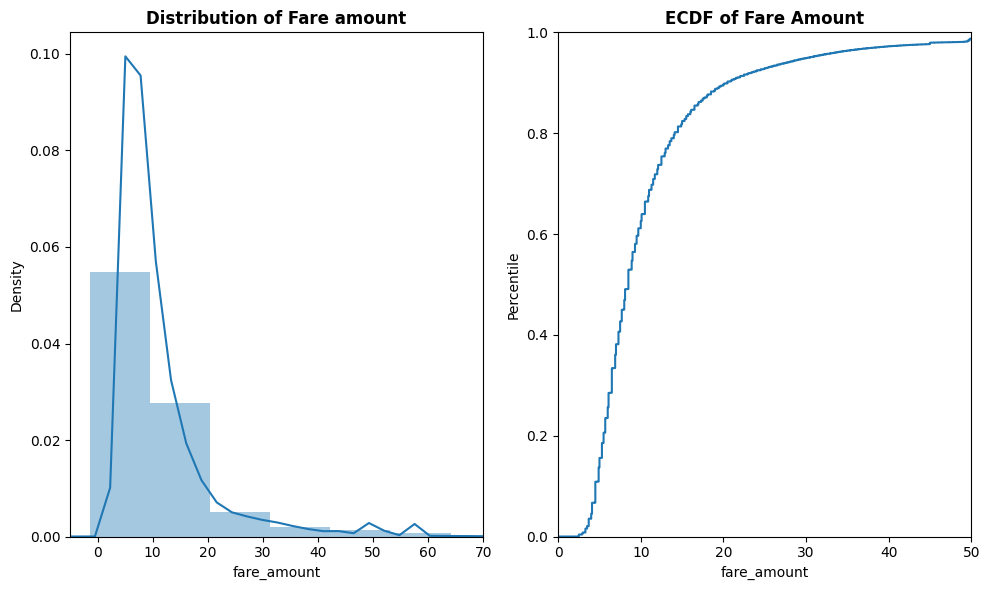

In [5]:
fig = plt.figure(figsize=(10,6))

ax=fig.add_subplot(1,2,1)
sns.distplot(df['fare_amount'])
ax.set_title('Distribution of Fare amount',fontweight='bold')
ax.set_xlim(-5,70)


#ECDF: empirical cumulative distribution function
ax=fig.add_subplot(1,2,2)
sns.ecdfplot(data=df, x="fare_amount")
ax.set_ylabel('Percentile')
ax.set_title('ECDF of Fare Amount',fontweight='bold')
ax.set_xlim(0,50)

fig.tight_layout()  
plt.show()

From the graph and the description tab previously seen, we can notice several <b>fare_amount</b> values which are <u>below 0</u> (i.e. negative, which is unexpected), and few values that correspond to 0 (equally unexpected).
There are also values above $100, which is interesting.

The ECDF shows how the distribution is actually very skewed, since most of the fares are below 20$, and there is an heavy right tail of larger fares.

In [6]:
print(f"There are {len(df[df['fare_amount'] < 0])} negative fares.")
print(f"There are {len(df[df['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(df[df['fare_amount'] > 100])} fares greater than $100.")

There are 13 negative fares.
There are 5 $0 fares.
There are 85 fares greater than $100.


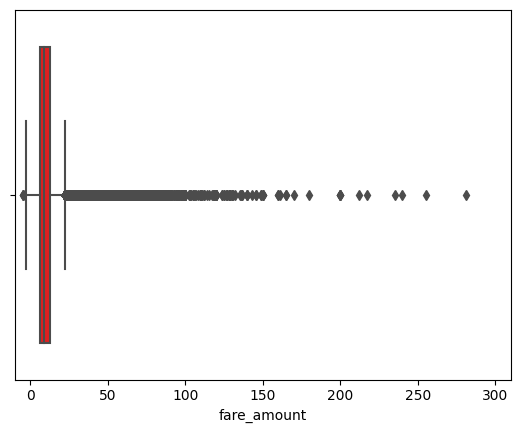

In [7]:
##Let's now focus the boxplot only on the target fare_amount
sns.boxplot(x=df['fare_amount'], color='red')
plt.xlim(-10, 310)
plt.show()

Also the boxplot shows us that there are many outliers in the target variable and so we have to deal with them.
Now, we are going to remove <b>un-real values</b>, which can be considered those <b>< 3$</b> and <b>>300 </b>.

In [8]:
df = df[df['fare_amount'].between(left = 3.0, right = 300)]

We can also have a better visualization of <b>fare_amount</b> by considering this feature as a discrete one and segmenting it into small intervals (bins) of values. In this way we can achieve a more clear view above the distribution of the variable, and simply which are the most recurrent ranges of fares.

Text(0.5, 1.0, 'Fare Binned')

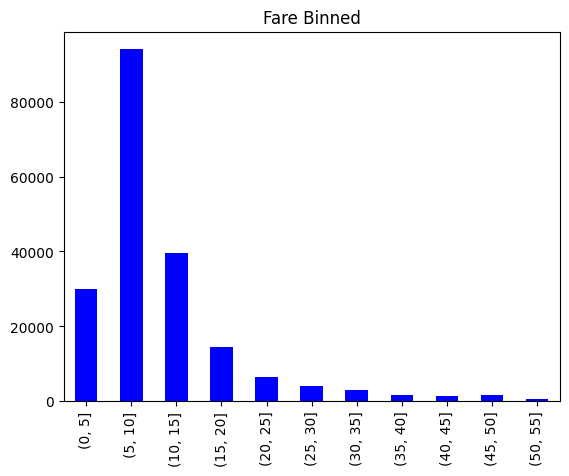

In [9]:
df['fare_bin'] = pd.cut(df['fare_amount'], bins=list(range(0,60,5)))
df.loc[df['fare_bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'
df['fare_bin'].value_counts().sort_index().plot.bar(color = 'b')
plt.title('Fare Binned')

I want to show a Box Plot of all the features of my dataset, so that we can have a deeper understanding of the actual values distribution for each feature.

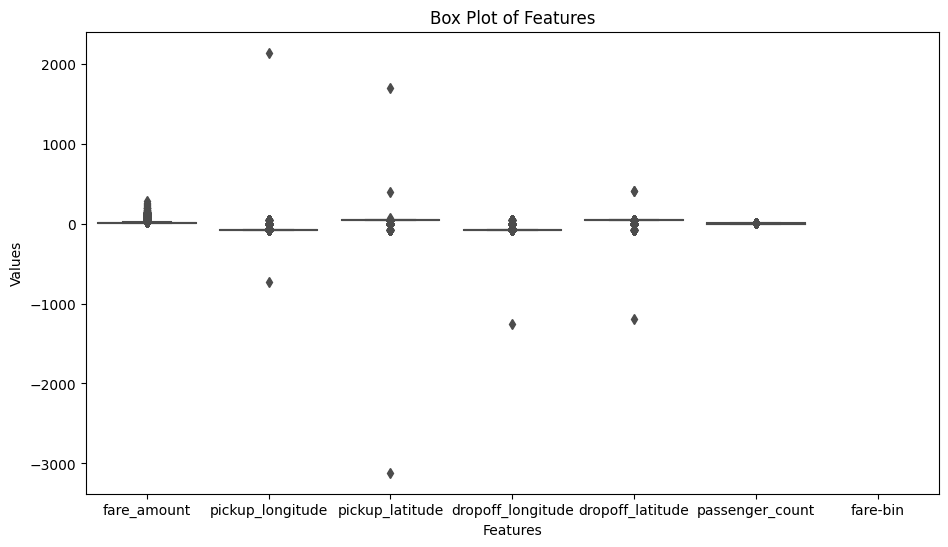

In [10]:
plt.figure(figsize=(11, 6))
sns.boxplot(data = df, color = 'red')
plt.title('Box Plot of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

<div class="alert alert-danger" role="alert">After conducting a preliminary analysis of our dataset features, we observed that there are <b>few missing values</b>. However, several columns exhibit a significant number of <b>outliers</b>. Our upcoming steps will focus on addressing these." <div>

In order to deal with the outliers, we can create a general function able to deal with them all in each feature of the dataset.
With this function we are able to address outliers specifically for each feature, by respecting the 'acceptance region' values of each column'.


In [11]:
def delete_outliers(df):
    return df[
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]
df = delete_outliers(df)

To understand why I decided to implement this 'filter', we need to make this consideration:
<b>NY Latitude</b>:	<i>40.730610</i>
<b>NY Longitude</b>: <i> -73.935242</i>
- `Pickup Longitude & Dropoff Longitude`: The proposed conditions ensure that the Pickup/Dropoff Longitude stay within the geographical boundaries of the city.
- `Pickup Latitude & Dropoff Latitude`: The proposed conditions ensure that the Pickup/Dropoff Latitude stay within the geographical boundaries of the city.
- `Passenger Count`: The common number of passengers is within 1 and 6, so exceeding values can be easily considered as noise.


### Longitude-Latitude

Text(0.5, 1.0, 'Dropoff Locations')

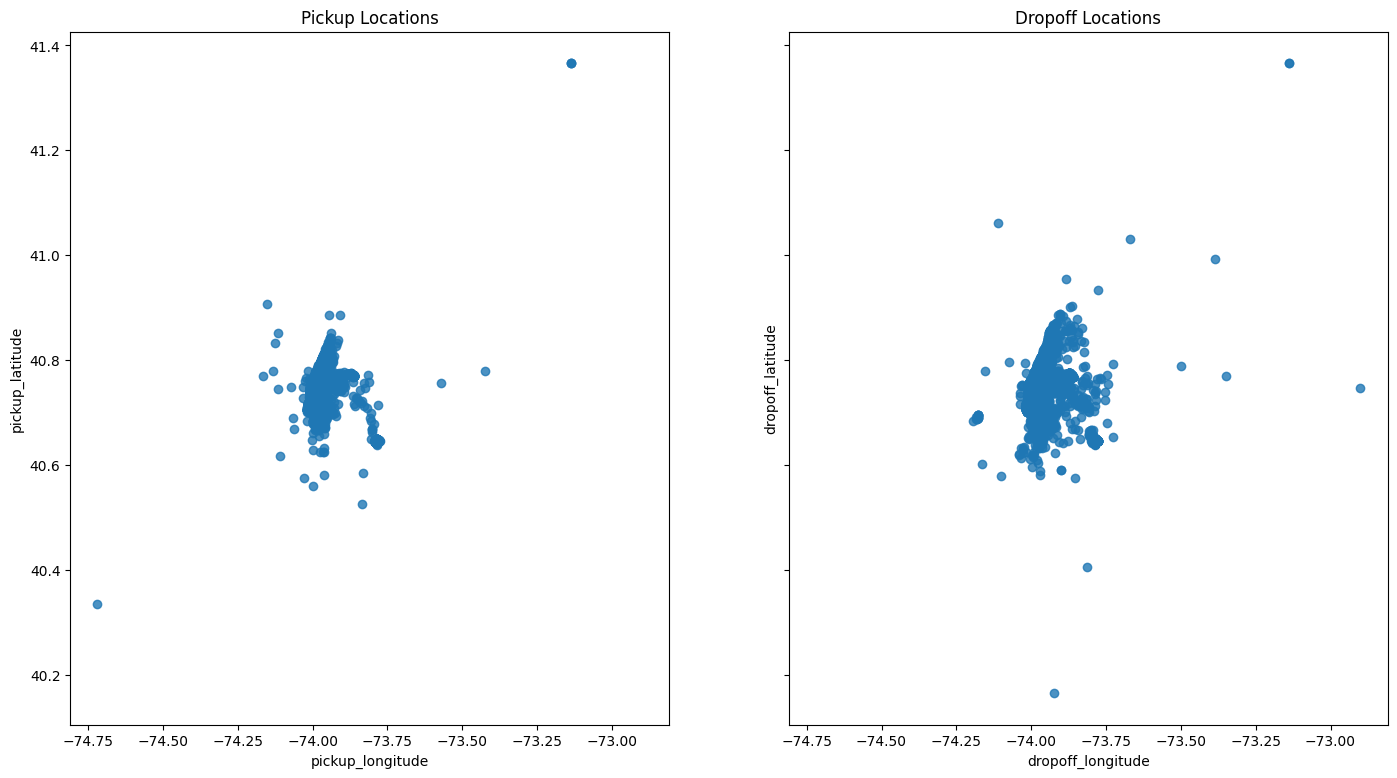

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (17, 9), sharex=True, sharey=True)

#flatten(): returns a 1D array instead of a 2D, and since the dropoff/pickup latitude features have this
#common nature, we can simply out access to them using a single index, and so consider "both as one".
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot(x='pickup_longitude', y='pickup_latitude', fit_reg = False, 
            data = df.sample(10000),seed = 100, ax = axes[0])
sns.regplot(x='dropoff_longitude', y='dropoff_latitude',fit_reg = False, 
            data = df.sample(10000),seed = 100, ax = axes[1])
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations')

I would also like to show the distributions of **pickup** and **dropoff coordinates** on the **New York city's map**.

Note: the ispiration's been taken from several other projects seen online.

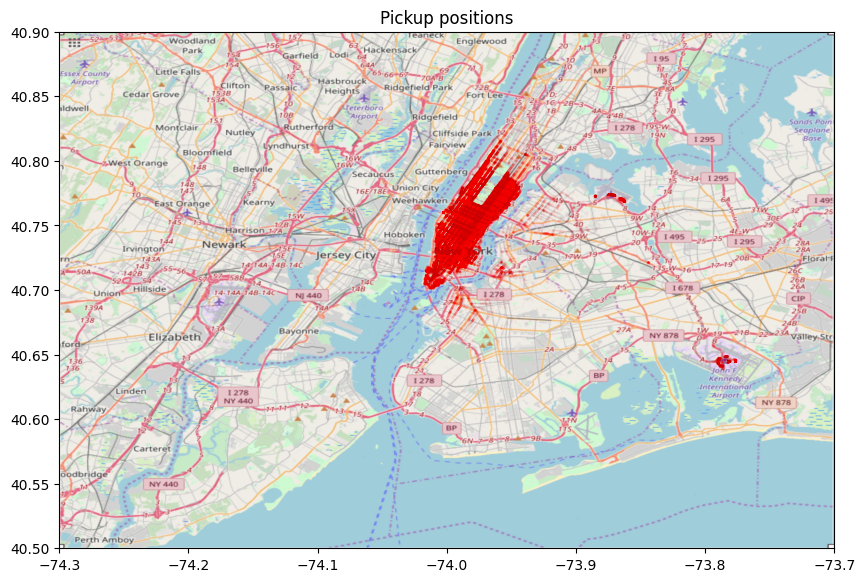

In [13]:
nycBorders = (-74.3, -73.7, 40.5, 40.9)
nyc = plt.imread('nyc.png')
def plotOnImage(df, _nycBox, nyc_map):
    fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
    ax.set_title("Pickup positions")
    ax.set_xlim((_nycBox[0], _nycBox[1]))
    ax.set_ylim((_nycBox[2], _nycBox[3]))
    ax.scatter(df.pickup_longitude, df.pickup_latitude, alpha=0.05, c='r', s=0.10)
    #alpha: This parameter controls the transparency or opacity of the scatter plot markers.
    #s: This parameter determines the size of the scatter plot markers. It can take a scalar. 
    ax.imshow(nyc, extent=_nycBox)
    #extent: The bounding box in data coordinates that the image will fill.
plotOnImage(df, nycBorders, nyc)

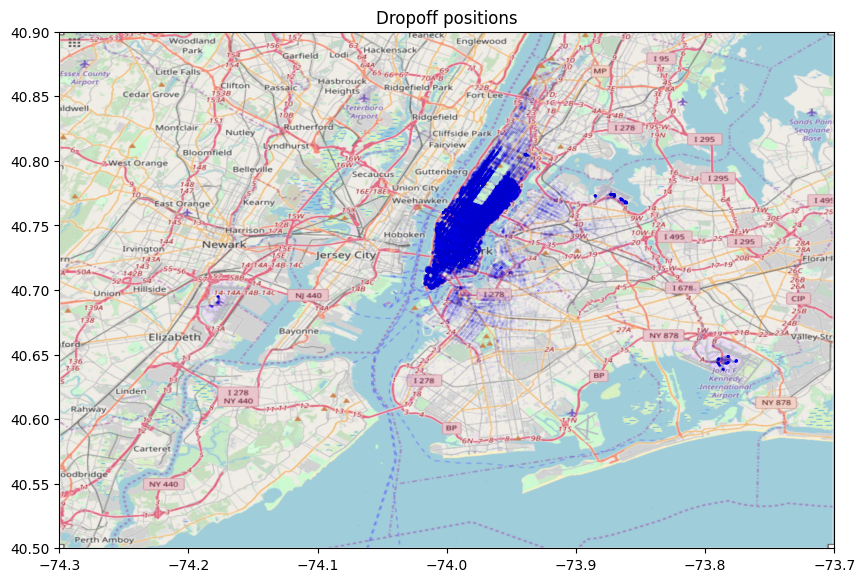

In [14]:
nycBorders = (-74.3, -73.7, 40.5, 40.9)
nyc = plt.imread('nyc.png')
def plotOnImage(df, _nycBox, nyc_map):
    fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
    ax.set_title("Dropoff positions")
    ax.set_xlim((_nycBox[0], _nycBox[1]))
    ax.set_ylim((_nycBox[2], _nycBox[3]))
    ax.scatter(df.dropoff_longitude, df.dropoff_latitude, alpha=0.05, c='b', s=0.10)
    #alpha: This parameter controls the transparency or opacity of the scatter plot markers.
    #s: This parameter determines the size of the scatter plot markers. It can take a scalar. 
    ax.imshow(nyc, extent=_nycBox)
    #extent: The bounding box in data coordinates that the image will fill.
plotOnImage(df, nycBorders, nyc)

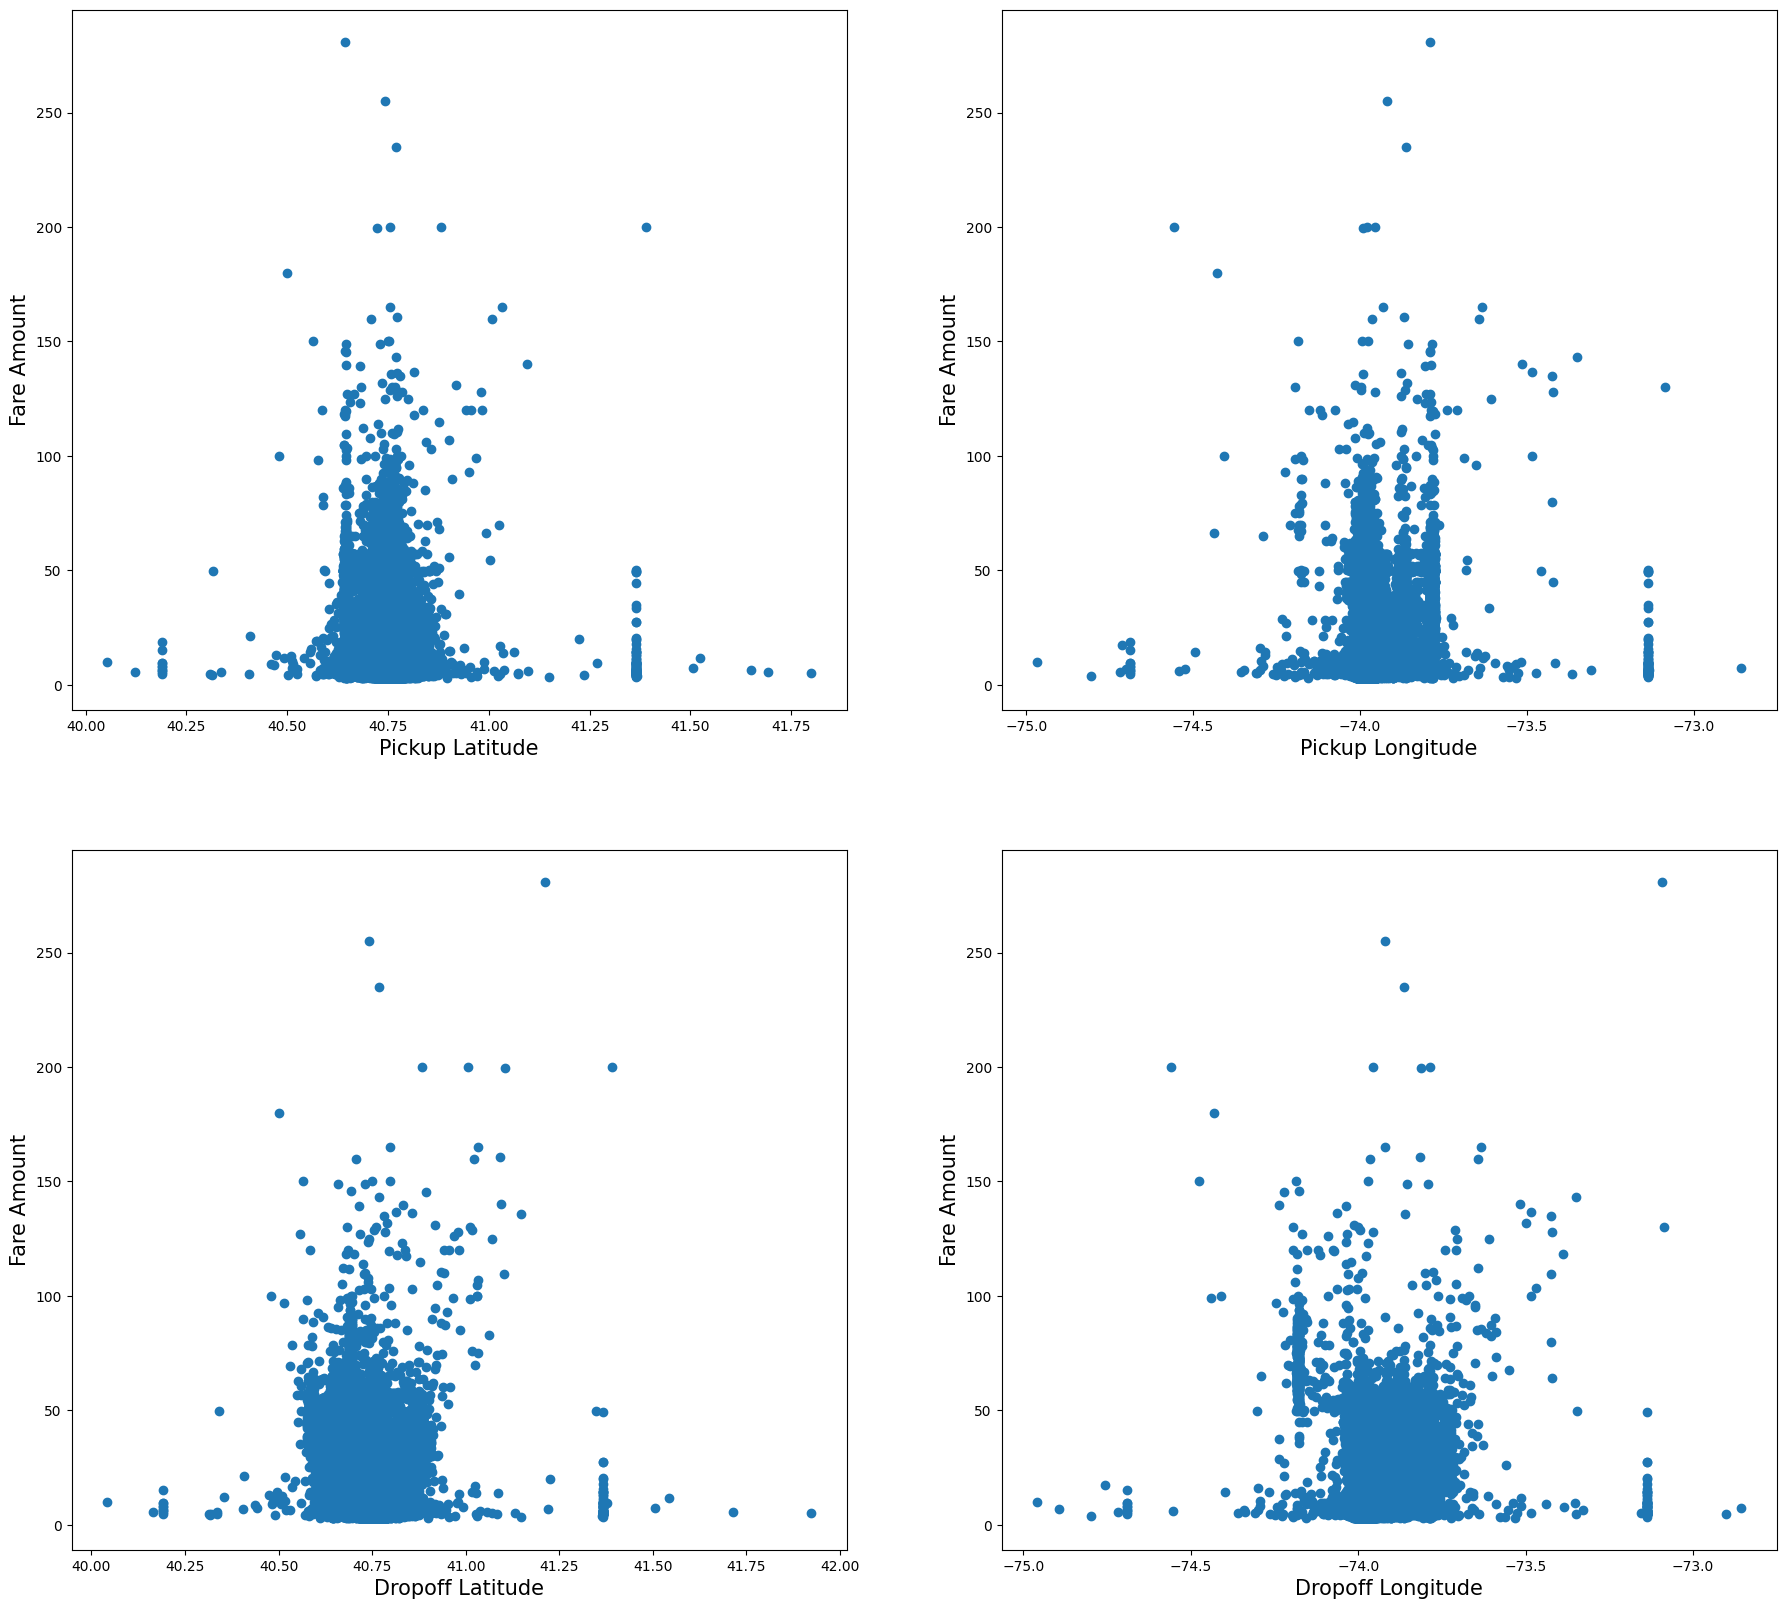

In [15]:
fig = plt.figure(figsize=(22,20))

ax1 = fig.add_subplot(2,2,1)
plt.xlabel('Pickup Latitude', fontsize=15)
plt.ylabel('Fare Amount', fontsize=15)

ax2 = fig.add_subplot(2,2,2)
plt.xlabel('Pickup Longitude', fontsize=15)
plt.ylabel('Fare Amount', fontsize=15)

ax3 = fig.add_subplot(2,2,3)
plt.xlabel('Dropoff Latitude',fontsize=15)
plt.ylabel('Fare Amount',fontsize=15)

ax4 = fig.add_subplot(2,2,4)
plt.xlabel('Dropoff Longitude',fontsize=15)
plt.ylabel('Fare Amount',fontsize=15)

# Plot the 2D scatter plot in the first subplot
ax1.scatter(df['pickup_latitude'], df['fare_amount'])
ax2.scatter(df['pickup_longitude'], df['fare_amount'])
ax3.scatter(df['dropoff_latitude'], df['fare_amount'])
ax4.scatter(df['dropoff_longitude'], df['fare_amount'])

plt.show()

We use the prior longitude and latitude data to calculate taxi distances traveled, subsequently associating them with actual fare amounts. This allows us to discern patterns within this relationship.

In order to better use these </b>coordinate variables</b>, we want to compute the distance between <u>pickup and dropoff points</u>. In this way we will be able to get a fare amount that proportionally correspond to a distance travelled.
In this case, we can use <i><b>Haversine distance</i></b>, since it computes the real distance between two points on a sphere given their longitudes and latitudes.

In [16]:
def haversine_np(lon1, lat1, lon2, lat2):
    
    """Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length."""
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) 
    #this py function applies np.radians to the entire list, in order to obtain them in radians.

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [17]:
df['distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])
display(df)

fare_amount            pickup_datetime  pickup_longitude  \
0              4.50  2009-06-15 17:26:21+00:00        -73.844311   
1             16.90  2010-01-05 16:52:16+00:00        -74.016048   
2              5.70  2011-08-18 00:35:00+00:00        -73.982738   
3              7.70  2012-04-21 04:30:42+00:00        -73.987130   
4              5.30  2010-03-09 07:51:00+00:00        -73.968095   
...             ...                        ...               ...   
199995         8.90  2011-03-24 01:38:50+00:00        -73.989939   
199996        14.10  2012-06-20 21:36:56+00:00        -74.005021   
199997         6.90  2012-08-04 19:18:00+00:00        -73.993203   
199998        18.00  2013-11-26 18:59:21+00:00        -73.994411   
199999        42.83  2015-01-06 10:21:48+00:00        -74.001656   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0             40.721319         -73.841610         40.712278                1   
1             40.711303         -73.979268         40.782004                1   
2             40.761270         -73.991242         40.750562                2   
3             40.733143         -73.991567         40.758092                1   
4             40.768008         -73.956655         40.783762                1   
...                 ...                ...               ...              ...   
199995        40.729423         -73.990683         40.758504                1   
199996        40.739912         -73.961319         40.766701                3   
199997        40.752092         -74.003508         40.732282                1   
199998        40.750884         -73.978532         40.785599                1   
199999        40.730495         -73.865578         40.770958                4   

        fare_bin fare-bin   distance  
0         (0, 5]      NaN   1.030117  
1       (15, 20]      NaN   8.444828  
2        (5, 10]      NaN   1.388653  
3        (5, 10]      NaN   2.797513  
4        (5, 10]      NaN   1.997902  
...          ...      ...        ...  
199995   (5, 10]      NaN   3.232236  
199996  (10, 15]      NaN   4.732445  
199997   (5, 10]      NaN   2.366196  
199998  (15, 20]      NaN   4.082631  
199999  (40, 45]      NaN  12.306362  

[194016 rows x 10 columns]

So here I extract the **maximum** and **minimum** values of the distance feature created.
Note: we can already expect 0 as minimum for obvious reasons.

In [18]:
max_value = df['distance'].max()
min_value = df['distance'].min()
print(f'the max value is {max_value}')
print(f'the min value is {min_value}')

the max value is 103.96964696962742
the min value is 0.0


Here I decided to personally set the minimum and maximum in order to create a smoother and more realistic <i>distance<i> feature.

In [19]:
# Set a range of values for a feature
min_value = 2  # Minimum desired value
max_value = 300  # Maximum desired value

# Boolean indexing to select rows within the desired range
selected_rows = (df['distance'] >= min_value) & (df['distance'] <= max_value)

# Assign the desired values to the selected rows
new_value = df.loc[selected_rows, 'distance']

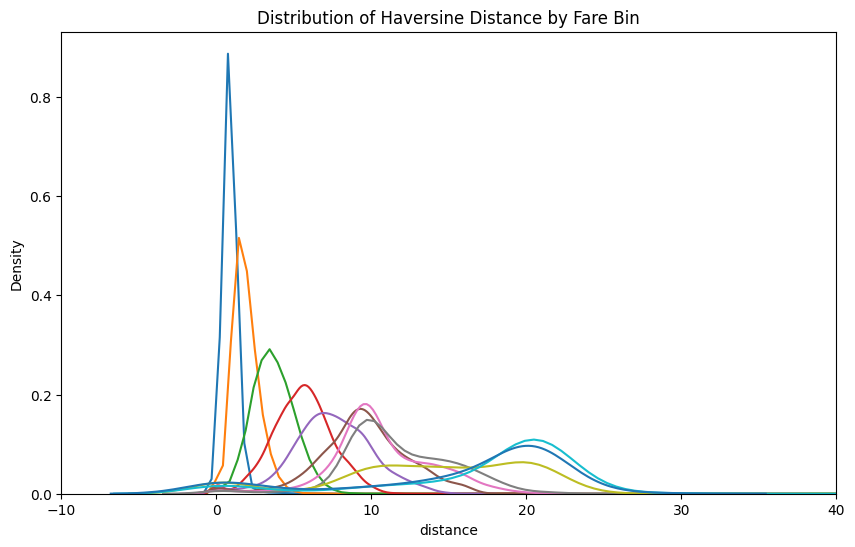

In [20]:
subset = df.sample(100000)

plt.figure(figsize = (10, 6))

for f, grouped in subset.groupby('fare_bin'):
    sns.kdeplot(grouped['distance'], label = f'{f}');
    
plt.xlim(-10,40)
plt.title('Distribution of Haversine Distance by Fare Bin');
plt.show()

Naturally, we observe that the shortest paths are the most frequently taken, highlighting that taxis are predominantly taken for short-distance city travel.

(3.0, 300.0)

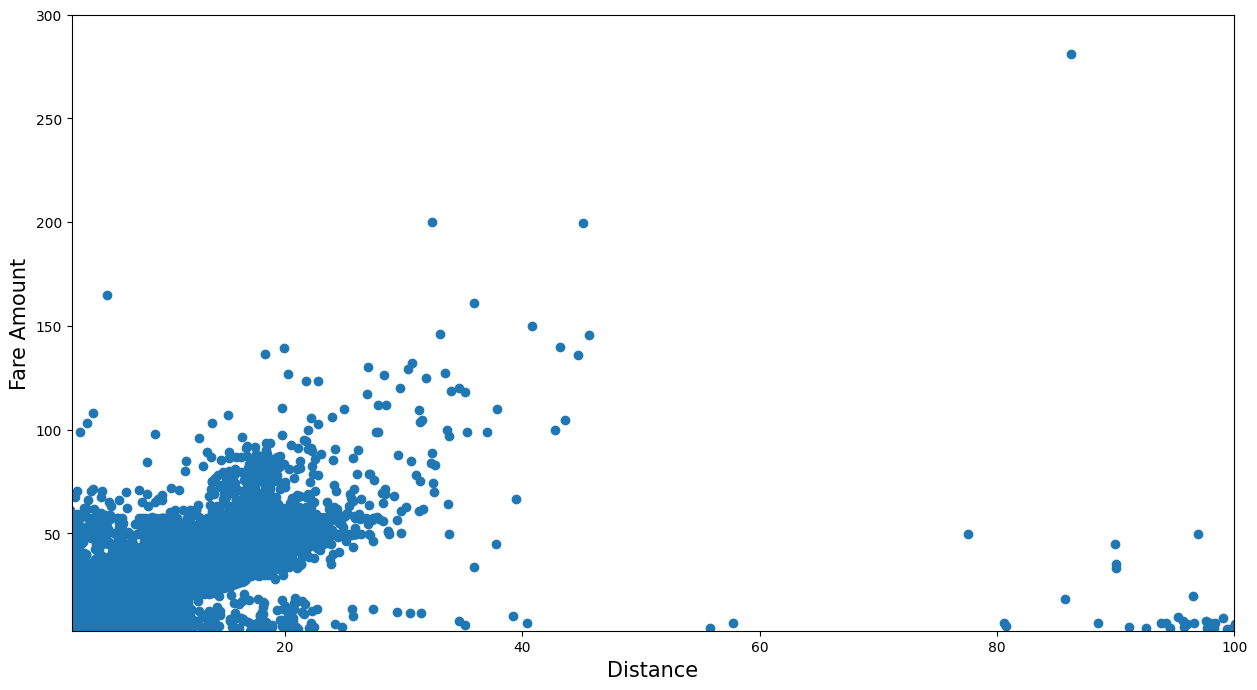

In [21]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Fare Amount', fontsize=15)
ax.scatter(df['distance'], df['fare_amount'])
plt.xlim(2,100)
plt.ylim(3,300)

I decided to extract **time features** from the dataset, since our target may have a significant relationship with this kind of data. In this way I can investigate many more relationships between my target and my features. 

In [22]:
#add features to the data
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = df.assign(
        #time features
        year=df.pickup_datetime.dt.year,
        dayofyear=df.pickup_datetime.dt.dayofyear,
        weekday=df.pickup_datetime.dt.dayofweek,
        time=(df.pickup_datetime.dt.hour+df.pickup_datetime.dt.minute/5),
        
)
display(df)

fare_amount           pickup_datetime  pickup_longitude  \
0              4.50 2009-06-15 17:26:21+00:00        -73.844311   
1             16.90 2010-01-05 16:52:16+00:00        -74.016048   
2              5.70 2011-08-18 00:35:00+00:00        -73.982738   
3              7.70 2012-04-21 04:30:42+00:00        -73.987130   
4              5.30 2010-03-09 07:51:00+00:00        -73.968095   
...             ...                       ...               ...   
199995         8.90 2011-03-24 01:38:50+00:00        -73.989939   
199996        14.10 2012-06-20 21:36:56+00:00        -74.005021   
199997         6.90 2012-08-04 19:18:00+00:00        -73.993203   
199998        18.00 2013-11-26 18:59:21+00:00        -73.994411   
199999        42.83 2015-01-06 10:21:48+00:00        -74.001656   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0             40.721319         -73.841610         40.712278                1   
1             40.711303         -73.979268         40.782004                1   
2             40.761270         -73.991242         40.750562                2   
3             40.733143         -73.991567         40.758092                1   
4             40.768008         -73.956655         40.783762                1   
...                 ...                ...               ...              ...   
199995        40.729423         -73.990683         40.758504                1   
199996        40.739912         -73.961319         40.766701                3   
199997        40.752092         -74.003508         40.732282                1   
199998        40.750884         -73.978532         40.785599                1   
199999        40.730495         -73.865578         40.770958                4   

        fare_bin fare-bin   distance  year  dayofyear  weekday  time  
0         (0, 5]      NaN   1.030117  2009        166        0  22.2  
1       (15, 20]      NaN   8.444828  2010          5        1  26.4  
2        (5, 10]      NaN   1.388653  2011        230        3   7.0  
3        (5, 10]      NaN   2.797513  2012        112        5  10.0  
4        (5, 10]      NaN   1.997902  2010         68        1  17.2  
...          ...      ...        ...   ...        ...      ...   ...  
199995   (5, 10]      NaN   3.232236  2011         83        3   8.6  
199996  (10, 15]      NaN   4.732445  2012        172        2  28.2  
199997   (5, 10]      NaN   2.366196  2012        217        5  22.6  
199998  (15, 20]      NaN   4.082631  2013        330        1  29.8  
199999  (40, 45]      NaN  12.306362  2015          6        1  14.2  

[194016 rows x 14 columns]

### Fare Amount-Time

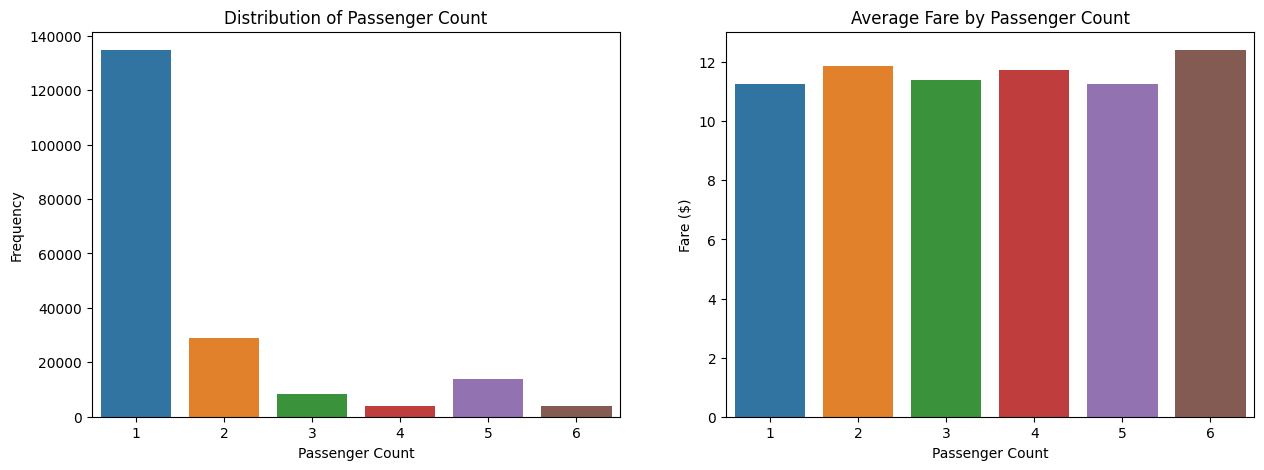

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Countplot of Passenger Count
sns.countplot(data=df, x='passenger_count', ax=ax[0])
ax[0].set_xlabel('Passenger Count')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Passenger Count')

# Plot 2: Barplot of Average Fare by Passenger Count
sns.barplot(data=df, x='passenger_count', y='fare_amount', ax=ax[1], ci=None)
ax[1].set_xlabel('Passenger Count')
ax[1].set_ylabel('Fare ($)')
ax[1].set_title('Average Fare by Passenger Count')

# Show the plots
plt.show()

Most taxi rides only have 1 passenger, but passenger count doesn't show any relationship to the fare amount. This indicates that taxi drivers charge for rides independently of the number of passengers.

Here we go further with the investigation between Fare Amount and Time features by plotting the relative graphs. We can notice some interesting relations.

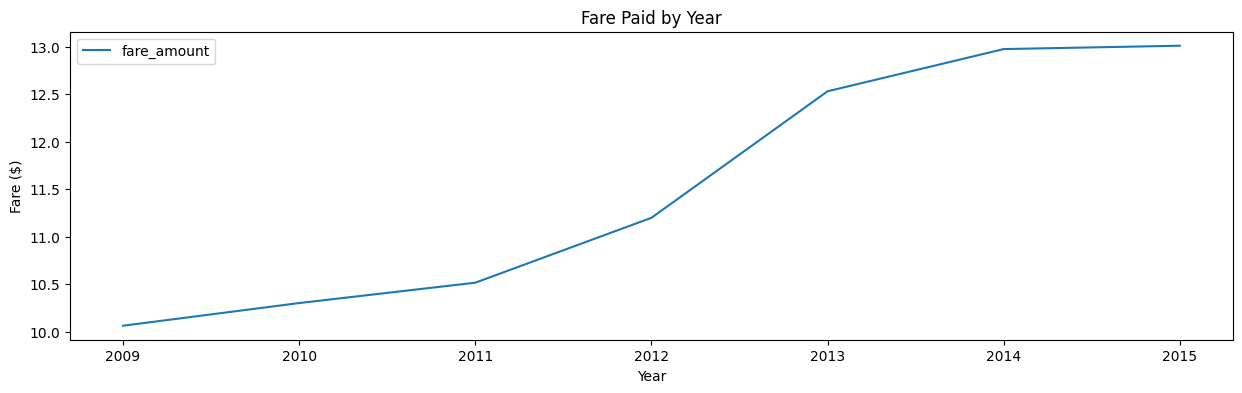

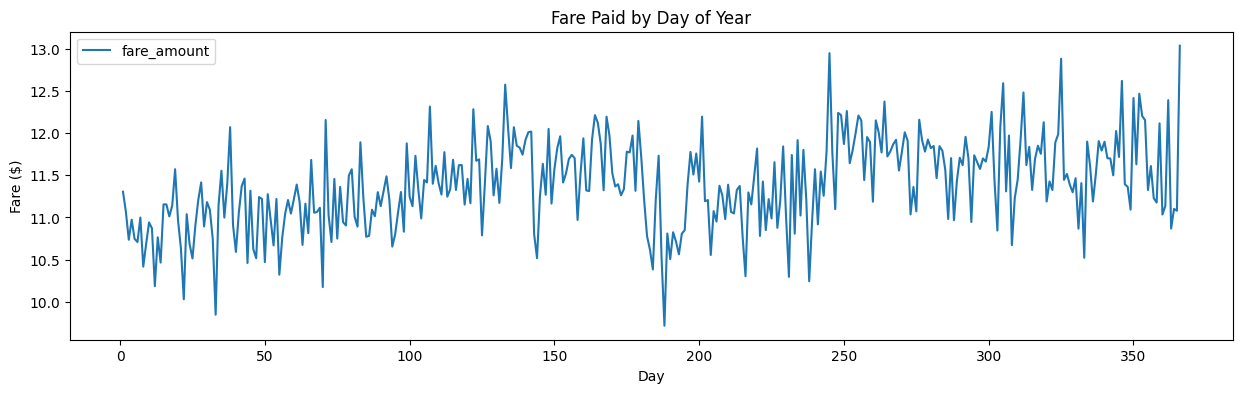

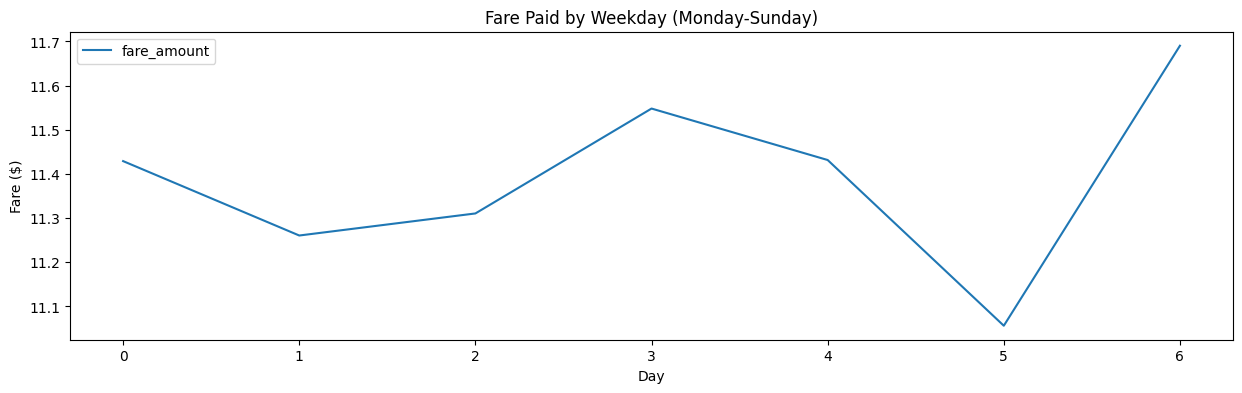

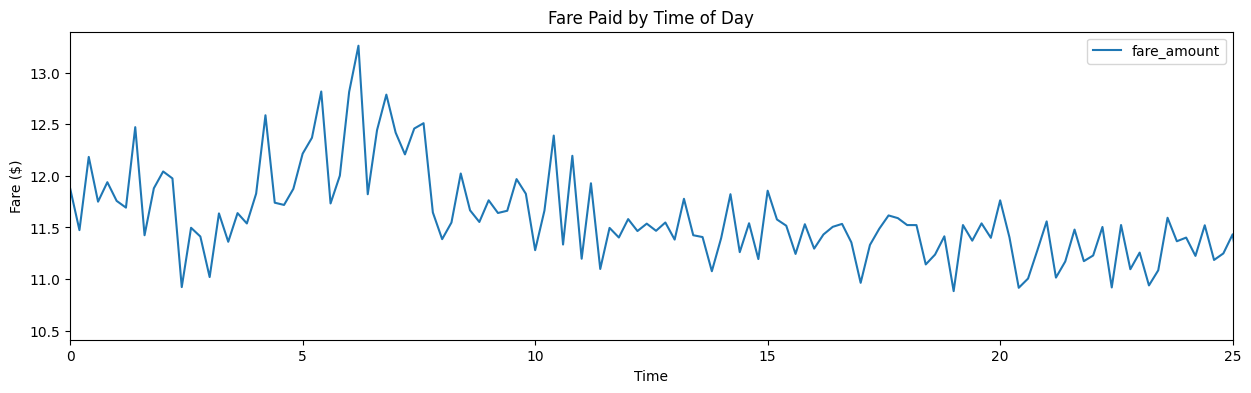

In [24]:
df.pivot_table('fare_amount', index='year').plot(figsize=(15,4))
plt.title('Fare Paid by Year')
plt.ylabel('Fare ($)')
plt.xlabel('Year')
df.pivot_table('fare_amount', index='dayofyear').plot(figsize=(15,4))
plt.title('Fare Paid by Day of Year')
plt.ylabel('Fare ($)')
plt.xlabel('Day')
df.pivot_table('fare_amount', index='weekday').plot(figsize=(15,4))
plt.title('Fare Paid by Weekday (Monday-Sunday)')
plt.ylabel('Fare ($)')
plt.xlabel('Day')
df.pivot_table('fare_amount', index='time').plot(figsize=(15,4))
plt.ylabel('Fare ($)')
plt.xlabel('Time')
plt.title('Fare Paid by Time of Day')
plt.xlim(0,25)
plt.show()

Fares are lowest on Saturdays (index 5) and highest on Sundays (index 6), but are overall quite stable throughout the week (note the scale of the y-axis).

Fares show a very large spike in pricing around 5-6am, which is very plausible considering the night service.

# Data Pre-Processing

In this section we go on with our model and we apply the necessary <b>preprocessing</b> tools to the dataset.

In [25]:
print(df.dtypes)

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
fare_bin                        category
fare-bin                          object
distance                         float64
year                               int64
dayofyear                          int64
weekday                            int64
time                             float64
dtype: object


In my model, I have different types of features:
- **Numerical Features** (float64, int64)
- **Datetime Features** (datetime64[ns, UTC])
- **Categorical Features** (category, object)

My dataset is fortunately very clean, with a high usability rate. Consequently, there are not many preprocessing steps required, which is advantageous.

Note: I have decided to remove the two categorical features (['fare_bin'] and ['fare_bin']), since they were not relevant up to this point anymore.

I basically applied **datetime** module in order to extract specific time references from the datetime feature of my dataset.

In [26]:
df['hour'] = df['pickup_datetime'].dt.hour
df['year'] = df['pickup_datetime'].dt.year
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear
df.drop(columns=['pickup_datetime'], inplace=True)
df.drop('fare_bin', axis=1, inplace=True)
# Update the list of datetime features
datetime_features = ['hour']

In [27]:
display(df)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0              4.50        -73.844311        40.721319         -73.841610   
1             16.90        -74.016048        40.711303         -73.979268   
2              5.70        -73.982738        40.761270         -73.991242   
3              7.70        -73.987130        40.733143         -73.991567   
4              5.30        -73.968095        40.768008         -73.956655   
...             ...               ...              ...                ...   
199995         8.90        -73.989939        40.729423         -73.990683   
199996        14.10        -74.005021        40.739912         -73.961319   
199997         6.90        -73.993203        40.752092         -74.003508   
199998        18.00        -73.994411        40.750884         -73.978532   
199999        42.83        -74.001656        40.730495         -73.865578   

        dropoff_latitude  passenger_count fare-bin   distance  year  \
0              40.712278                1      NaN   1.030117  2009   
1              40.782004                1      NaN   8.444828  2010   
2              40.750562                2      NaN   1.388653  2011   
3              40.758092                1      NaN   2.797513  2012   
4              40.783762                1      NaN   1.997902  2010   
...                  ...              ...      ...        ...   ...   
199995         40.758504                1      NaN   3.232236  2011   
199996         40.766701                3      NaN   4.732445  2012   
199997         40.732282                1      NaN   2.366196  2012   
199998         40.785599                1      NaN   4.082631  2013   
199999         40.770958                4      NaN  12.306362  2015   

        dayofyear  weekday  time  hour  
0             166        0  22.2    17  
1               5        1  26.4    16  
2             230        3   7.0     0  
3             112        5  10.0     4  
4              68        1  17.2     7  
...           ...      ...   ...   ...  
199995         83        3   8.6     1  
199996        172        2  28.2    21  
199997        217        5  22.6    19  
199998        330        1  29.8    18  
199999          6        1  14.2    10  

[194016 rows x 13 columns]

Here I decided to **downsize** my dataset since the limited computational power of my computer.

In [28]:
df = df.sample(n=11437, random_state=42)

I applied a Custom Transformer in order to preprocess the relevant features of my dataset in a suitable way.

In [29]:
##As said before, I have different types of features, and in the following code we are going to preprocess them all

# Numerical features
num_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance', 'year', 'dayofyear', 'weekday','time','hour']

# Preprocessing for numerical features (scaling)
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    #('pca', PCA(n_components=4))
    ])

# Bundle preprocessing for numerical, datetime, and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features)],
    remainder='passthrough')


# Define the preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocess the data
df_transformed = pipeline.fit_transform(df)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
3338            5.7        -73.970700        40.767234         -73.977998   
196251          4.1        -73.954442        40.781017         -73.950102   
146326          8.5        -74.009633        40.722397         -74.011234   
52343          13.0        -73.978626        40.762018         -74.000069   
4108            9.7        -73.981893        40.732407         -73.971867   
...             ...               ...              ...                ...   
53181           5.0        -73.982498        40.768334         -73.974991   
12421           5.3        -74.015827        40.710840         -74.007450   
194292          8.1        -73.969047        40.763267         -73.949865   
8557            7.7        -73.982190        40.768735         -73.955493   
173590          5.5        -73.991159        40.765713         -73.985642   

        dropoff_latitude  passenger_count  distance  year  dayofyear  weekday  \
3338           40.758106                1  1.185843  2011        284        1   
196251         40.785515                1  0.619028  2011        210        4   
146326         40.708249                1  1.577971  2012        276        1   
52343          40.731247                1  3.866713  2013         15        1   
4108           40.766484                1  3.879734  2011          5        2   
...                  ...              ...       ...   ...        ...      ...   
53181          40.777534                1  1.201797  2014        322        1   
12421          40.715517                1  0.876355  2009         81        6   
194292         40.772135                1  1.891403  2012         33        3   
8557           40.773690                1  2.313245  2010        117        1   
173590         40.760567                1  0.736639  2013        172        4   

        time  hour  
3338    19.8    11  
196251  23.2    13  
146326  16.8    10  
52343   16.2    14  
4108    13.2     9  
...      ...   ...  
53181   20.2    10  
12421   20.4    11  
194292  21.2    13  
8557    24.6    20  
173590  30.6    23  

[11437 rows x 12 columns]

In [30]:
fare_object = df.select_dtypes(include=['object'])
# Drop one of the columns with the same name (e.g., drop the integer column)
df = df.drop(columns=fare_object.columns[0])

In [31]:
display(df)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
3338            5.7        -73.970700        40.767234         -73.977998   
196251          4.1        -73.954442        40.781017         -73.950102   
146326          8.5        -74.009633        40.722397         -74.011234   
52343          13.0        -73.978626        40.762018         -74.000069   
4108            9.7        -73.981893        40.732407         -73.971867   
...             ...               ...              ...                ...   
53181           5.0        -73.982498        40.768334         -73.974991   
12421           5.3        -74.015827        40.710840         -74.007450   
194292          8.1        -73.969047        40.763267         -73.949865   
8557            7.7        -73.982190        40.768735         -73.955493   
173590          5.5        -73.991159        40.765713         -73.985642   

        dropoff_latitude  passenger_count  distance  year  dayofyear  weekday  \
3338           40.758106                1  1.185843  2011        284        1   
196251         40.785515                1  0.619028  2011        210        4   
146326         40.708249                1  1.577971  2012        276        1   
52343          40.731247                1  3.866713  2013         15        1   
4108           40.766484                1  3.879734  2011          5        2   
...                  ...              ...       ...   ...        ...      ...   
53181          40.777534                1  1.201797  2014        322        1   
12421          40.715517                1  0.876355  2009         81        6   
194292         40.772135                1  1.891403  2012         33        3   
8557           40.773690                1  2.313245  2010        117        1   
173590         40.760567                1  0.736639  2013        172        4   

        time  hour  
3338    19.8    11  
196251  23.2    13  
146326  16.8    10  
52343   16.2    14  
4108    13.2     9  
...      ...   ...  
53181   20.2    10  
12421   20.4    11  
194292  21.2    13  
8557    24.6    20  
173590  30.6    23  

[11437 rows x 12 columns]

In [32]:
class_counts = df['fare_amount'].value_counts()
rare_classes = class_counts[class_counts == 1].index.tolist()
filter_condition = ~df['fare_amount'].isin(rare_classes)
df['fare_amount'] = df[filter_condition]
df['fare_amount'].dropna(inplace=True)
print(class_counts)
print(df['fare_amount'].isna().sum())

6.50     553
4.50     455
8.50     447
5.30     362
6.10     343
        ... 
45.83      1
51.10      1
39.33      1
21.40      1
45.33      1
Name: fare_amount, Length: 398, dtype: int64
169


In [34]:
display(df) #now the dataset is clean,and 'fare_amount' doesn't show any other missing values.

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
3338            5.7        -73.970700        40.767234         -73.977998   
196251          4.1        -73.954442        40.781017         -73.950102   
146326          8.5        -74.009633        40.722397         -74.011234   
52343          13.0        -73.978626        40.762018         -74.000069   
4108            9.7        -73.981893        40.732407         -73.971867   
...             ...               ...              ...                ...   
53181           5.0        -73.982498        40.768334         -73.974991   
12421           5.3        -74.015827        40.710840         -74.007450   
194292          8.1        -73.969047        40.763267         -73.949865   
8557            7.7        -73.982190        40.768735         -73.955493   
173590          5.5        -73.991159        40.765713         -73.985642   

        dropoff_latitude  passenger_count  distance  year  dayofyear  weekday  \
3338           40.758106                1  1.185843  2011        284        1   
196251         40.785515                1  0.619028  2011        210        4   
146326         40.708249                1  1.577971  2012        276        1   
52343          40.731247                1  3.866713  2013         15        1   
4108           40.766484                1  3.879734  2011          5        2   
...                  ...              ...       ...   ...        ...      ...   
53181          40.777534                1  1.201797  2014        322        1   
12421          40.715517                1  0.876355  2009         81        6   
194292         40.772135                1  1.891403  2012         33        3   
8557           40.773690                1  2.313245  2010        117        1   
173590         40.760567                1  0.736639  2013        172        4   

        time  hour  
3338    19.8    11  
196251  23.2    13  
146326  16.8    10  
52343   16.2    14  
4108    13.2     9  
...      ...   ...  
53181   20.2    10  
12421   20.4    11  
194292  21.2    13  
8557    24.6    20  
173590  30.6    23  

[11437 rows x 12 columns]

In [35]:
X = df.drop('fare_amount', axis=1)  # Features
y = df['fare_amount']  # Target variable

pickup_longitude  pickup_latitude  dropoff_longitude  \
103837        -73.981354        40.781578         -73.993156   
93248         -73.955170        40.784837         -73.994467   
53135         -73.986350        40.760360         -73.991483   
95940         -73.978803        40.764223         -73.916494   
142538        -73.985238        40.723765         -73.886418   
...                  ...              ...                ...   
168558        -73.994426        40.694825         -73.995279   
116945        -73.991971        40.738454         -74.006355   
16016         -73.983458        40.749240         -73.991920   
35926         -74.016715        40.715580         -73.984282   
70582         -73.946678        40.778999         -73.987373   

        dropoff_latitude  passenger_count  distance  year  dayofyear  weekday  \
103837         40.755421                1  3.071782  2015         83        1   
93248          40.732595                2  6.681613  2009         65        4   
53135          40.758172                1  0.495775  2010        318        6   
95940          40.783598                1  5.668385  2013        285        5   
142538         40.768577                1  9.696049  2012        268        0   
...                  ...              ...       ...   ...        ...      ...   
168558         40.734486                1  4.407919  2009         53        6   
116945         40.734432                1  1.290992  2013         58        2   
16016          40.733487                1  1.889984  2010        141        4   
35926          40.763154                3  5.950299  2009        102        6   
70582          40.744274                4  5.159783  2015        101        5   

        time  hour  
103837  10.8    10  
93248   26.0    17  
53135   15.2    13  
95940    4.0     0  
142538   8.0     5  
...      ...   ...  
168558  26.8    22  
116945  22.8    13  
16016   26.8    19  
35926   13.4     8  
70582   33.0    22  

[9149 rows x 11 columns]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30, shuffle=True)

pickup_longitude  pickup_latitude  dropoff_longitude  \
162429        -73.977158        40.777522         -73.873208   
75716         -73.996872        40.762757         -73.991362   
130532        -73.964163        40.807408         -73.873170   
1103          -73.984497        40.764413         -73.971187   
161705        -73.968181        40.755650         -73.989955   
...                  ...              ...                ...   
73152         -74.001890        40.750762         -73.994810   
98809         -73.977667        40.749724         -73.915652   
10221         -73.979040        40.747460         -74.002712   
37570         -73.979490        40.739782         -73.991813   
163991        -73.977608        40.725780         -73.971500   

        dropoff_latitude  passenger_count  distance  year  dayofyear  weekday  \
162429         40.774377                2  8.754540  2009        351        3   
75716          40.758082                1  0.696409  2010        211        4   
130532         40.774388                3  8.489440  2014         97        0   
1103           40.759184                1  1.262027  2012        302        6   
161705         40.756671                1  1.836372  2013        188        6   
...                  ...              ...       ...   ...        ...      ...   
73152          40.750275                1  0.598473  2012        307        4   
98809          40.822567                2  9.630682  2011         79        6   
10221          40.733472                1  2.527581  2010        268        5   
37570          40.754465                2  1.933542  2010        122        6   
163991         40.754411                1  3.222919  2014        131        6   

        time  hour  
162429   9.0     7  
75716   13.8     9  
130532  26.0    15  
1103    16.2     6  
161705   7.8     7  
...      ...   ...  
73152   27.6    18  
98809   14.2     3  
10221   17.0    16  
37570    1.8     1  
163991  22.4    17  

[2288 rows x 11 columns]

We applied **Simple Imputer** because it kept giving missing values.

In [ ]:
##ALERT!!!
###Questa parte non va bene, in teoria questo passaggio va fatto dopo la separazione di train e test !!!!

##In teoria ora va bene, ma c'è da verificare se il modello runna con questa nuova "disposizione".

imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the 'fare_amount' column
imputer.fit(df[['fare_amount']])

# Transform and replace missing values in the 'fare_amount' column
df['fare_amount'] = imputer.transform(df[['fare_amount']])

# Model Configuration

We need to establish the potential models and then choose the most promising ones by utilizing a **nested cross-validation process**. This approach seamlessly integrates both hyperparameter optimization and model selection within a unified code structure.

But before going through with this configuration phase, I want to summarize the algorithms I decided to use:
- **Linear Regression**: Linear Regression is a fundamental statistical and machine learning technique used for modeling the relationship between a dependent variable (often referred to as the <u>target</u>) and one or more independent variables (often referred to as <u>features</u>). It is called "linear" because it assumes that this relationship is approximately linear, meaning that changes in the independent variables have a linear effect on the dependent variable. I have considered it because it is the "building block" of regression analysis.
- **Ridge Regressor**: Ridge Regression is a variant of linear regression, and it is particularly useful in situations where the dataset exhibits multicollinearity, which occurs when two or more independent variables in a linear regression model are highly correlated. I decided to use it in order to prevent this problem whenever my model would have presented multicollinearity.
- **Lasso Regressor**: Lasso Regression is a variant of linear regression that is useful for feature selection and addressing multicollinearity. It is particularly beneficial when dealing with high-dimensional datasets where many features may not be relevant. It, as Ridge Regressor, uses a regularization technique for controlling different aspect of training (e.g. overfitting).
- **Random Forest Regressor**: Random Forest Regressor is a machine learning algorithm that belongs to the ensemble learning family. It's a powerful and versatile tool for regression tasks; it combines the predictions of multiple decision trees to make more accurate and robust predictions. It builds a forest of decision trees and aggregates their outputs. Each tree in the Random Forest is a decision tree, which recursively splits the data into subsets based on feature values to make predictions. Some of its strengths are: High Predictive Accuracy, robustivness to outliers, feature importance, reduced risk of overfitting (thanks to randomness), interpretability and so on.
- **XGB Regressor**: XGBoost Regressor is a machine learning algorithm that stands for "Extreme Gradient Boosting." It is a powerful and popular technique for regression tasks. It belongs to the family of gradient boosting algorithms, which are an ensemble learning techniques that combine the predictions of multiple weak learners (usually decision trees) to create a strong predictive model. XGBoost includes L1 (Lasso) and L2 (Ridge) regularization terms in its objective function. This helps prevent overfitting and improves model generalization; It is highly efficient and can be parallelized, making it suitable for multicore processors and distributed computing environments.
- **Gradient Boosting Regressor**: Gradient Boosting Regressor is a powerful machine learning algorithm that is used for regression tasks. It builds trees sequentially, with each new tree correcting the errors of the previous ones. It focuses on areas where the previous models have made mistakes. During the construction of decision trees, the algorithm uses gradient descent optimization to find the best split points. This allows for efficient and effective tree growth.

In [37]:
model_pipeline = IMBPipeline([
    ('trans', preprocessor),
    ('dim_reduction', PCA(n_components=5)),
    ('regressor', GradientBoostingRegressor())
])

In [38]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'passenger_count',
                                                   'distance', 'year',
                                                   'dayofyear', 'weekday',
                                                   'time', 'hour'])])),
                ('dim_reduction', PCA(n_components=5)),
                ('regressor', GradientBoostingRegressor())])

In [39]:
y_pred = model_pipeline.predict(X_test)

In [40]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9, 3, 4, 5]
    }
]

# Define different configurations for regressor models
regressor_configs = [
    {
        'regressor': [LinearRegression()]
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': loguniform(1e-3, 1e3)
    },
    {
        'regressor': [Lasso()],
        'regressor__alpha': loguniform(1e-3, 1e3)
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 80, 100],
        'regressor__max_depth': [10, 20, 30],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf' : [1,2],
        'regressor__max_features' : ['sqrt'],
        'regressor__oob_score' : [True, False],
        'regressor__bootstrap' : [True, False]
    },
    {
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': np.linspace(10, 100).astype(int),
        'regressor__max_depth': [3, 4, 5, 6],
        'regressor__learning_rate': [0.05, 0.1, 0.2],
        'regressor__min_child_weight': [1, 2, 3],
        'regressor__gamma': [0, 0.1, 0.2],
        'regressor__subsample': [0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.7, 0.8, 0.9]
    },
    {
        'regressor': [GradientBoostingRegressor()],
        'regressor__n_estimators': [50, 100, 150],
        'regressor__max_depth': [3, 4, 5],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__subsample': [0.8, 0.9, 1.0],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__loss': ['ls', 'lad', 'huber']
    }
]
# ls: MSE loss;  lad: MAE loss;  huber: mix of both.

The following code generates all possible combinations of hyperparameter configurations for both dimensionality reduction methods (dim_reduction_configs) and regressor models (regressor_configs). It combines these configurations into a list called all_configs. The total number of configurations is then printed.

The purpose of generating these configurations is typically for **hyperparameter tuning** and **model selection**. By exploring a wide range of hyperparameters and their combinations, I can then identify the best-performing model through randomized search.

In [41]:
all_configs = []
for configuration in itertools.product(dim_reduction_configs, regressor_configs):
    all_configs.append((dict(itertools.chain(*(e.items() for e in configuration)))))
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 12'

In [42]:
all_configs[:4]

[{'dim_reduction': [None], 'regressor': [LinearRegression()]},
 {'dim_reduction': [None],
  'regressor': [Ridge()],
  'regressor__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f9f960ffa90>},
 {'dim_reduction': [None],
  'regressor': [Lasso()],
  'regressor__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f9f95ec01c0>},
 {'dim_reduction': [None],
  'regressor': [RandomForestRegressor()],
  'regressor__n_estimators': [50, 80, 100],
  'regressor__max_depth': [10, 20, 30],
  'regressor__min_samples_split': [2, 5],
  'regressor__min_samples_leaf': [1, 2],
  'regressor__max_features': ['sqrt'],
  'regressor__oob_score': [True, False],
  'regressor__bootstrap': [True, False]}]

# Model Selection

As said before, we perform model selection through **nested cross-validation**. Its structure is mainly divided into two different loops: 
- *inner loop* : hyperparameter optimization using Random Search.
- *outer loop* : Cross validation using as hyperparameters the best candidates identified in the inner loop.


The following implementation represents the so called *inner loop* of <u>nested cross-validation.

In [43]:
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,  # Number of random combinations to try
    n_jobs=-1,  # Use all available CPU cores
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Evaluation metric for regression
    random_state=42,  # Random seed for reproducibility
    refit = True
)

In [44]:
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['pickup_longitude',
                                                                                'pickup_latitude',
                                                                                'dropoff_longitude',
                                                                                'dropoff_latitude',
                                                                                'passenger_count',
                                                                                'distance',
                                                                                'year',
                                                                                'dayofyear',
                                                                                'weekday',
                                                                                'time',
                                                                                'hour'])])),
                                             ('dim_reduction',
                                              PCA(n_compo...
                                         'regressor': [GradientBoostingRegressor()],
                                         'regressor__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                         'regressor__loss': ['ls', 'lad',
                                                             'huber'],
                                         'regressor__max_depth': [3, 4, 5],
                                         'regressor__min_samples_leaf': [1, 2,
                                                                         4],
                                         'regressor__min_samples_split': [2, 5,
                                                                          10],
                                         'regressor__n_estimators': [50, 100,
                                                                     150],
                                         'regressor__subsample': [0.8, 0.9,
                                                                  1.0]}],
                   random_state=42, scoring='neg_mean_squared_error')

The following step is then the *outer loop* of <u>nested cross-validation</u>.

In [45]:
cv_results = cross_validate(model_pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=12, return_estimator=True, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ....................................., score=-27.343 total time=   1.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[CV] END ....................................., score=-34.949 total time=   1.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[CV] END ....................................., score=-24.690 total time=   1.8s
[CV] END ....................................., score=-17.834 total time=   1.7s
[CV] END ....................................., score=-29.683 total time=   1.9s
[CV] END ....................................., score=-17.352 total time=   1.6s
[CV] END ....................................., score=-23.757 total time=   1.8s
[CV] END ....................................., score=-24.758 total time=   1.6s
[CV] END ....................................., score=-22.180 total time=   1.6s
[CV] END .....................

In the following code we can see our working cross validation, which then prints the output score (according the metric used, here **rmse**) for each fold.

In [46]:
cv_scores = cross_val_score(
    model_pipeline, X_train, y_train, 
    scoring='neg_mean_squared_error',  # Evaluation metric for regression
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available CPU cores
)

# Convert negative MSE scores to RMSE scores
rmse_scores = np.sqrt(-cv_scores)

# Print RMSE scores for each fold
for i, rmse in enumerate(rmse_scores):
    print(f"Fold {i+1} RMSE: {rmse}")

# Calculate and print the mean RMSE
mean_rmse = rmse_scores.mean()
print(f"Mean RMSE: {mean_rmse}")

Fold 1 RMSE: 5.716866983116997
Fold 2 RMSE: 4.833175747389453
Fold 3 RMSE: 4.461467480920396
Fold 4 RMSE: 4.812933513139217
Fold 5 RMSE: 5.175016614370621
Mean RMSE: 4.9998920677873375


In [47]:
for index, estimator in enumerate(cv_results['estimator']):
    print(estimator.named_steps['dim_reduction'])# Access the dimensionality reduction step
    print(estimator.named_steps['regressor'])  # Access the regressor
    print(cv_results['test_score'][index])  # Access the test scores
    print('-' * 10)


PCA(n_components=5)
GradientBoostingRegressor()
-27.343476347518628
----------
PCA(n_components=5)
GradientBoostingRegressor()
-34.9488009911097
----------
PCA(n_components=5)
GradientBoostingRegressor()
-24.69004794944048
----------
PCA(n_components=5)
GradientBoostingRegressor()
-17.83411514523982
----------
PCA(n_components=5)
GradientBoostingRegressor()
-29.683382884111722
----------
PCA(n_components=5)
GradientBoostingRegressor()
-17.352406548094844
----------
PCA(n_components=5)
GradientBoostingRegressor()
-23.757278178223743
----------
PCA(n_components=5)
GradientBoostingRegressor()
-24.757816901103205
----------
PCA(n_components=5)
GradientBoostingRegressor()
-22.180442310872397
----------
PCA(n_components=5)
GradientBoostingRegressor()
-18.505979659268274
----------
PCA(n_components=5)
GradientBoostingRegressor()
-26.79740420351
----------
PCA(n_components=5)
GradientBoostingRegressor()
-28.07708330175471
----------


Now I check for the best model:

In [48]:
best_params = rs.best_params_
score = rs.best_score_
print(best_params)
print(score)

{'dim_reduction': None, 'regressor': RandomForestRegressor(max_depth=20, max_features='sqrt', oob_score=True), 'regressor__bootstrap': True, 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100, 'regressor__oob_score': True}
-16.64169121244246


In [49]:
for estimator in cv_results['estimator']:
    # Fit the estimator on the training data
    estimator.fit(X_train, y_train)
    
    # Make predictions on the training and test sets
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    
    # Calculate RMSE for training and test sets
    rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f'RMSE on training set: {rmse_train:.2f}')
    print(f'RMSE on test set: {rmse_test:.2f}')
    print('-' * 10)


RMSE on training set: 4.32
RMSE on test set: 5.15
----------
RMSE on training set: 4.32
RMSE on test set: 5.14
----------
RMSE on training set: 4.32
RMSE on test set: 5.14
----------
RMSE on training set: 4.32
RMSE on test set: 5.15
----------
RMSE on training set: 4.32
RMSE on test set: 5.14
----------
RMSE on training set: 4.32
RMSE on test set: 5.14
----------
RMSE on training set: 4.32
RMSE on test set: 5.14
----------
RMSE on training set: 4.32
RMSE on test set: 5.15
----------
RMSE on training set: 4.32
RMSE on test set: 5.15
----------
RMSE on training set: 4.32
RMSE on test set: 5.15
----------
RMSE on training set: 4.32
RMSE on test set: 5.15
----------
RMSE on training set: 4.32
RMSE on test set: 5.14
----------


From the previous we have selected the best candidate model. In this final step, we re-run the hyperparameter optmization fixing the modelling apporach and varying the hyperparameters in a range close to selected model's one.

In [50]:
best_model_pipeline = IMBPipeline([
    ('trans', preprocessor),
    ('regressor',RandomForestRegressor(max_depth=20,max_features='sqrt',oob_score=True, n_estimators=100,
    min_samples_split=2, min_samples_leaf=1, bootstrap=True))
])

In [51]:
params = {
        'regressor__n_estimators': [50, 80, 100, 150],
        'regressor__max_depth': [10, 20, 30, 40],
        'regressor__min_samples_split': [2, 5, 8],
        'regressor__min_samples_leaf' : [1,2,4],
        'regressor__max_features' : ['sqrt'],
        'regressor__oob_score' : [True, False],
        'regressor__bootstrap' : [True, False]
}
rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    cv=5,  # Use regular cross-validation for regression
    n_iter=20,
    scoring='neg_mean_squared_error'  # Use appropriate regression metric
)

In [52]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['pickup_longitude',
                                                                                'pickup_latitude',
                                                                                'dropoff_longitude',
                                                                                'dropoff_latitude',
                                                                                'passenger_count',
                                                                                'distance',
                                                                                'year',
                                                                                'dayofyear',
                                                                                'weekday',
                                                                                'time',
                                                                                'hour'])])),
                                             ('regressor',
                                              RandomForestReg...
                                                                    max_features='sqrt',
                                                                    oob_score=True))]),
                   n_iter=20,
                   param_distributions={'regressor__bootstrap': [True, False],
                                        'regressor__max_depth': [10, 20, 30,
                                                                 40],
                                        'regressor__max_features': ['sqrt'],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         8],
                                        'regressor__n_estimators': [50, 80, 100,
                                                                    150],
                                        'regressor__oob_score': [True, False]},
                   scoring='neg_mean_squared_error')

In [53]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'passenger_count',
                                                   'distance', 'year',
                                                   'dayofyear', 'weekday',
                                                   'time', 'hour'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=40, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=8,
                                       n_estimators=80))])

# Model Evaluation

Here I decided to evaluate the model through some of the most relevant metrics in term of regression models:
- **R2 score**
- **Root Mean Squared Error**, or **RMSE**
- **Mean Absolute Percentage Error** or, **MAPE**

In [54]:
r2 = r2_score(y_test, rs_best.best_estimator_.predict(X_test))
print(f'The R2 Score for our model is: {r2}')
rmse = sqrt(mean_squared_error(y_test, rs_best.best_estimator_.predict(X_test)))
print(f'The RMSE for our model is: {rmse}')
mape = mean_absolute_percentage_error(y_test, rs_best.best_estimator_.predict(X_test))
mape = round(mape,3)
print(f'The Mean absolute percentage error for our model is: {mape}')


The R2 Score for our model is: 0.7453304367459239
The RMSE for our model is: 4.328323386118582
The Mean absolute percentage error for our model is: 0.219


Here I computed the **Root Mean squared error**, or **RMSE**, and then I plotted the actual comparison between predicted and true values.

## Predicted vs True Fares

RMSE: 4.328323386118582


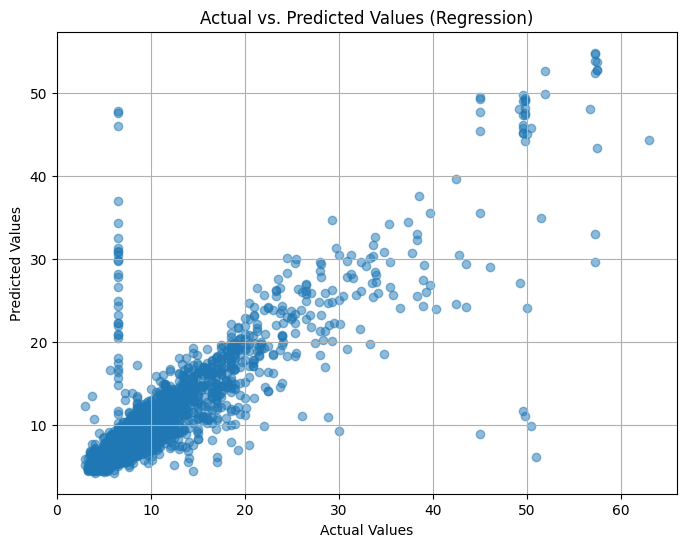

In [55]:
y_pred = rs_best.best_estimator_.predict(X_test)
print("RMSE:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Regression)')
plt.grid(True)
plt.show()

## Residual Plot

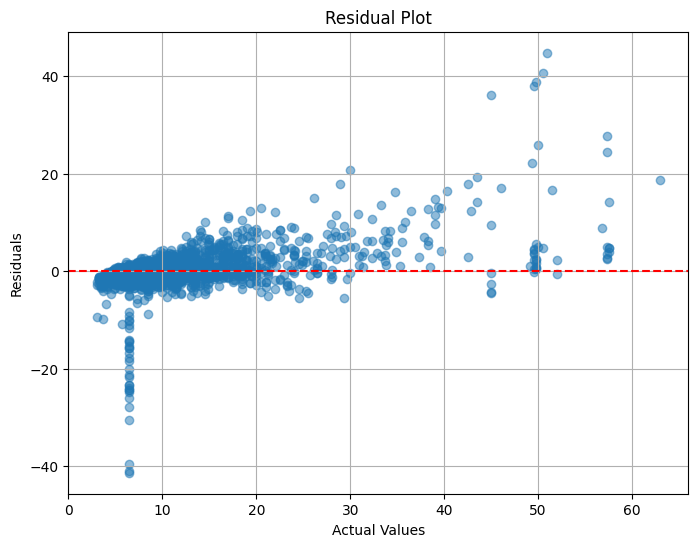

In [56]:
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

As observable, the data points are grouped around the red line (indicating good predictions) up to a certain x value and then become more scattered or show a different pattern beyond that point, it suggests that my model may perform well for common or typical values of x but may struggle with less common or extreme values of x. This phenomenon can occur when the dataset contains outliers or rare values that are challenging for the model to predict accurately.

## Correlation Matrix

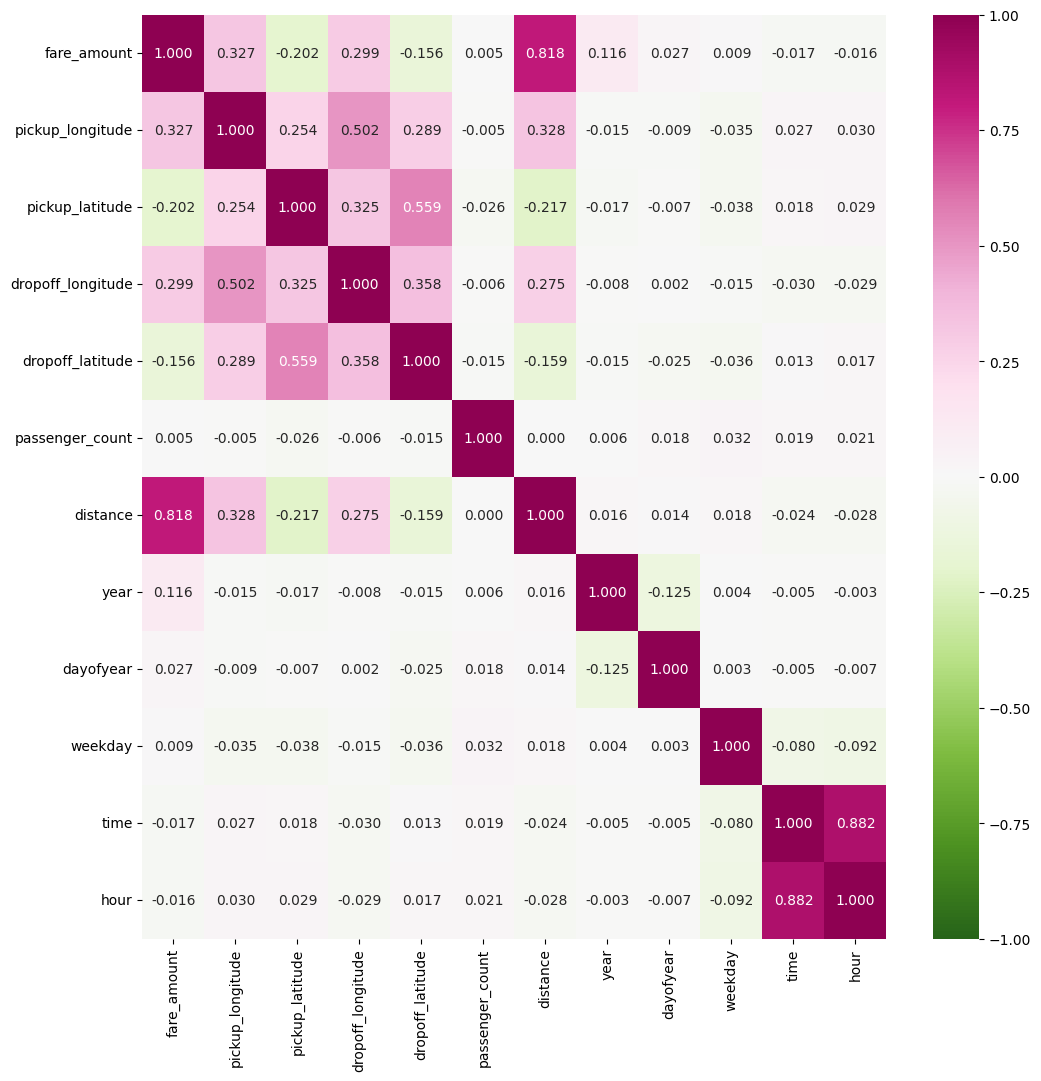

In [57]:
corrs = df.corr()
plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

## Predicted vs True Fares (Distribution) 

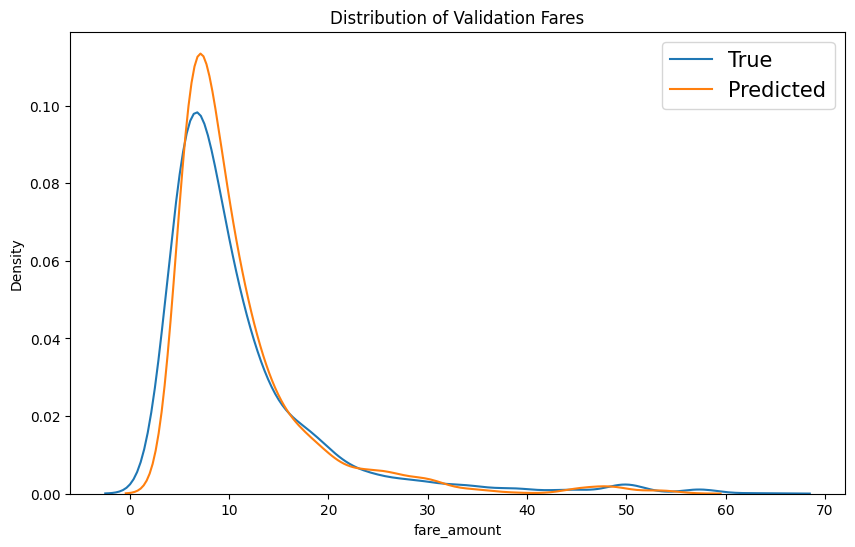

In [58]:
plt.figure(figsize = (10, 6))
sns.kdeplot(y_test, label = 'True')
sns.kdeplot(y_pred, label = 'Predicted')
plt.legend(prop = {'size': 15})
plt.title("Distribution of Validation Fares");

## ECDF

**ECDF** provides a way to graphically represent the cumulative distribution of the data points and is particularly useful for understanding the spread and central tendency of a dataset.
From this plot we can understand different things, and if we observe the range 0.5-0.9 (50th to 90th percentile) we notice that fare values are mainly concentrated within the range \$10-$20, and that's totally understandable.

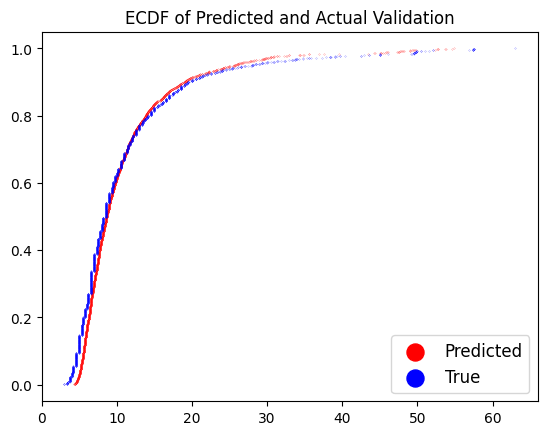

In [59]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    return x, y

xv, yv = ecdf(y_pred)
xtrue, ytrue = ecdf(y_test)

# Plot the ecdfs on same plot
plt.scatter(xv, yv, s= 0.06,  c = 'r', marker = '.', label = 'Predicted')
plt.scatter(xtrue, ytrue, s = 0.06, c = 'b', marker = '.', label = 'True')
plt.title('ECDF of Predicted and Actual Validation')
plt.legend(markerscale = 100, prop = {'size': 12})

# Extra: Additional Model

## AdaBoost Regressor

In [60]:
adaboost = AdaBoostRegressor(base_estimator=None, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(50, 250, 4, dtype=int),  # Number of weak learners
    'learning_rate': [0.01, 0.1],       # Learning rate
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    adaboost, 
    param_distributions=param_grid, 
    n_iter=100,               # Number of random combinations to try
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=5,                     # Number of cross-validation folds
    n_jobs=-1,                # Use all available CPU cores
    random_state=42,          # Random seed for reproducibility
    verbose=1                 # Print progress
)

# Fit the random search to your training data
random_search.fit(X_train, y_train)

best_ada = rs.best_estimator_

# Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:", random_search.best_params_)
print("Best RMSE:", (-random_search.best_score_) ** 0.5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'n_estimators': 50, 'learning_rate': 0.01}
Best RMSE: 4.644195454216736


In [61]:
ada = best_ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
r = r2_score(y_test, y_pred_ada)
r_approx = round(r,4)
print(f'The R2 score for this AdaBoost regressor is: {r_approx}')

The R2 score for this AdaBoost regressor is: 0.75


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=29bb9f9a-4572-4052-980a-1b6ff842f175' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>